# Machine Learning for Single-Cell Biology
***

Winter Semester 2025/26<br />
Manfred Claassen, Maximilian Wirth, Jan Schleicher
<br />
***

## Assignment 2

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.optimize as opt
import seaborn as sns

import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from umap import UMAP

from tqdm.auto import tqdm

sns.set_style("ticks")
%matplotlib inline

In [7]:
DATA_PATH = "data/"

### Task 1

In [8]:
# Load the data
expression_data_1 =  np.loadtxt(os.path.join(DATA_PATH, "expression_data_1.txt"))
metadata_1 = pd.read_csv(os.path.join(DATA_PATH, "metadata_1.txt"), header=None, names=["cell_type"])

In [ ]:
def task_01_lle(data: np.array, dim_n: int, k=5) -> np.array:
    """
    This function performs a locally-linear embedding.
    :param data: numpy array of shape (n_samples, n_features)
    :param dim_n: reduced dimensionality
    :param k: number of nearest neighbors
    :return: numpy array of shape (n_samples, dim_n)
    """
    #embedding = np.zeros((data.shape[0], dim_n))

    #########################
    # 1) Compute nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=k).fit(data)
    distances, indices = nbrs.kneighbors(data)

    # 2) Compute Weight Matrix by reconstruction Xi from k-neighbors
    N = data.shape[0]
    W = sp.lil_matrix((N, N), dtype=np.float64)
    regularization_tol = 1e-3

    for i in range(N): 
        # extracting original datapoint Xi, and neighboring datapoints Xj to Xi
        Xi = data[i, :]
        neighbor_indices = indices[i]
        Xj = data[neighbor_indices, :]

        # Centering datapoints Xj to Xi -> needed for covarianz matrix
        Z = Xj - Xi

        # Computing covarianz matrix with centered data and it's transposed -> reflects the geometrical relations between neighbors -> needed for reconstruction
        C = np.dot(Z, Z.T)

        # Regularization -> Ridge Transformation -> we add the some variance to the main diagonal of the covarianz matrix -> avoid singular covarianz matrix
        C += np.eye(k) * regularization_tol * np.trace(C)

        # Solving the system 
        w = np.linalg.solve(C, np.ones(k))

        # Norming the weights -> ensuring the constraint is fullfilled -> weights only add up to 1
        w /= np.sum(w)

        W[i, neighbor_indices] = w

    W = W.tocsr()

    # 3) Embedding -> computing Yi, by solving eigenvalue problem
    I = sp.identity(N, dtype=W.dtype)
    M = (I-W).T.dot(I-W)

    k_eigenvectors = dim_n + 1
    eigenvalues, eigenvectors = eigsh(M, k=k_eigenvectors, which='SM')

    embedding = eigenvectors[:, 1:]

    
    #########################

    return embedding

### Task1A - Step by Step description of the LLE algorithm

1. Neighborhood Selection
In the first step, we assign neighbors to each data point X, for example using k-nearest neighbors algorithm

2. Weight Matrix Construction
Next we compute the weights, that best linearly construct each data point X from its neighbors, by solving the constraint least-squares problem. 
This preserves the local relationships

3. Output Embedding
In the last step we compute low-dimensional embedding vectors Y, by using linear algebra do reduce reconstruction error. This minimization is achieved by finding the smallest eigenvectors of a sparse matrix. 


array([[ 0.00426579, -0.01038743],
       [ 0.00426579,  0.05030083],
       [ 0.00426579, -0.01039095],
       ...,
       [ 0.00426579,  0.05151981],
       [ 0.00426579,  0.05001903],
       [ 0.00426579, -0.01038481]], shape=(2638, 2))

array([0.00426579, 0.00426579, 0.00426579, ..., 0.00426579, 0.00426579,
       0.00426579], shape=(2638,))

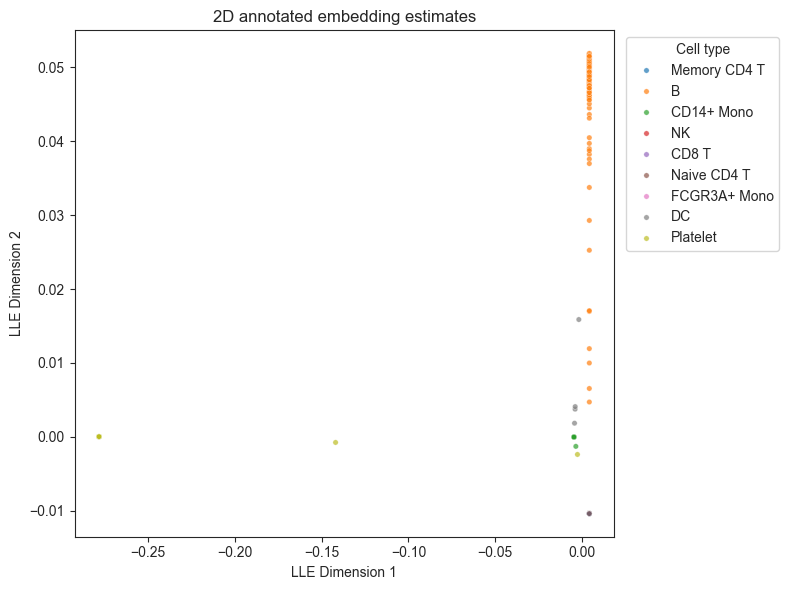

In [16]:
# Task 1A
# Compute locally linear embedding for given data
task_01_solution = task_01_lle(data=expression_data_1, dim_n=2)
display(task_01_solution)

display(task_01_solution[:,0])
# Plot the embedding, annotated with cell type identity
#########################
x_values = task_01_solution[:,0]
y_values = task_01_solution[:,1]


df_annotated = pd.DataFrame(
    task_01_solution,
    columns=["LLE1", "LLE2"]
)

df_annotated["Cell_Type"] = metadata_1


plt.figure(figsize=(8, 6))
sns.scatterplot(
    data = df_annotated,
    x = "LLE1", 
    y = "LLE2",
    hue="Cell_Type",
    s = 15,
    alpha = 0.7
)

plt.title("2D annotated embedding estimates")
plt.xlabel("LLE Dimension 1")
plt.ylabel("LLE Dimension 2")

plt.legend(
    title = 'Cell type',
    loc ='upper left', 
    bbox_to_anchor=(1.01, 1),
    frameon = True
)

plt.tight_layout()
plt.show()

#########################

c:\Users\Anwender\Desktop\Uni_Tuebingen\Master\1. Semester\ML Single Cell\Assignments\Assignment02\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


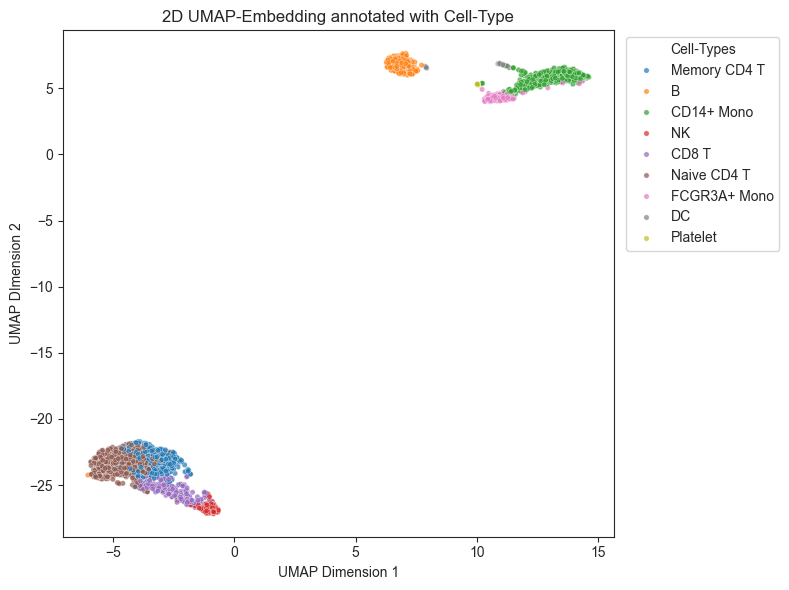

In [17]:
# Task 1B
# Compute UMAP embedding of the given data and plot it
#########################
umap = UMAP(n_components=2, random_state=42)
umap_embedding = umap.fit_transform(expression_data_1)

df_umap = pd.DataFrame(
    umap_embedding, 
    columns = ["UMAP1", "UMAP2"]
)

df_umap["Cell_Type"] = metadata_1

plt.figure(figsize=(8, 6))

sns.scatterplot(
    data = df_umap,
    x = "UMAP1",
    y = "UMAP2",
    hue = "Cell_Type",
    s = 15,
    alpha = 0.7
)

plt.title("2D UMAP-Embedding annotated with Cell-Type")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP DImension 2")

plt.legend(
    title = "Cell-Types",
    loc = "upper left",
    bbox_to_anchor = (1.01,1),
    frameon = True
)

plt.tight_layout()
plt.show()
#########################

In [12]:
# Task 1C
# Compute LLE and UMAP embeddings with different numbers of neighbors
#########################
# INSERT YOUR CODE HERE #
#########################

**Provide your text answers for Task 1D here**

### Task 2

In [13]:
# Load data
expression_data_2 = pd.read_csv(os.path.join(DATA_PATH, "expression_data_2.txt"), sep="\t", index_col=0)
metadata_2 = pd.read_csv(os.path.join(DATA_PATH, "metadata_2.txt"), sep="\t", index_col=0)

In [14]:
def task_02_quantile_normalization(data: pd.DataFrame, meta_data: pd.DataFrame, target: str) -> pd.DataFrame:
    """
    This function performs quantile normalization as batch correction.
    :param data: pandas DataFrame of shape (n_cells, n_genes)
    :param meta_data: pandas DataFrame containing the target variable to correct for
    :param target: target variable in meta_data
    :return: pandas DataFrame with quantile normalized data
    """
    corrected_data = data.copy()

    #########################
    # INSERT YOUR CODE HERE #
    #########################

    return corrected_data

In [15]:
# Task 2
task_02_solution = task_02_quantile_normalization(data=expression_data_2, meta_data=metadata_2, target="celltype")

# Compute UMAP and plot uncorrected and corrected data with batch and celltype annotation
#########################
# INSERT YOUR CODE HERE #
#########################

**Provide your text answers for Task 2B here**